In [1]:
import numpy as np
import matplotlib.pyplot as plt

from modules.kernels import kernels
from modules.utils import read, get_train_test
from modules.svm import svm
from modules.measure import accuracy

import warnings
warnings.filterwarnings('ignore')

In [2]:
empty = [0]
degree = [2, 3, 4, 5]
beta = [1, 2, 3, 4, 5]
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

In [3]:
def predict(kernel, omega, omegas, x, x_train, y_train):
    return np.sign(np.sum(omegas * y_train * np.array([kernel(x, y) for y in x_train])) + omega)

def class_to_int(target_class):
    return 0 if target_class == 1 else 1

In [4]:
def cross_validation(parts, calc_assessment, x, y, kernel, params):
    x_test, y_test, x_train, y_train = get_train_test(x, y, parts, True)
    best_params = [0, 0, 0]
    for c in C:
        for p in params:
            kernel_p = lambda x1, y1: kernel(x1, y1, p)
            number_classes = len({'P': 1, 'N': -1})
            confusion_matrix = np.zeros((number_classes, number_classes))
            for part in range(parts):
                omega, omegas = svm(x_train[part], y_train[part], c, kernel_p)
                for x1, y1 in zip(x_test[part], y_test[part]):
                    y_predicted = class_to_int(predict(kernel_p, omega, omegas, x1, x_train[part], y_train[part]))
                    y_actual = class_to_int(y1)
                    confusion_matrix[y_actual][y_predicted] += 1
            assessment = calc_assessment(confusion_matrix)
            if best_params[0] < assessment:
                best_params = assessment, c, p
    return best_params

def find_best(parts, calc_assessment, x, y):
    ker_res = {}
    for (kernel_name, kernel) in kernels.items():
        if kernel_name == "linear":
            name = "unnecessary"
            params = empty
        elif kernel_name == "polynomial":
            name = "degree"
            params = degree
        else:
            name = "beta"
            params = beta
        res = cross_validation(parts, calc_assessment, x, y, kernel, params)
        ker_res[kernel_name] = res
        print(kernel_name + ":" +
              " assessment = " + str(res[0]) +
              ", best C = " + str(res[1]) +
              ", best " + name + " = " + str(res[2]))
    return ker_res

In [5]:
def graph(x, y, kernel, params):
    def get_color(cur_y):
        return 'green' if cur_y >= 0 else 'red'

    c, p = params
    kernel_p = lambda x1, y1: kernel(x1, y1, p)
    omega, omegas = svm(x, y, c, kernel_p)

    for i in range(len(x)):
        plt.scatter(x[i, 0], x[i, 1], marker=('+' if y[i] == 1 else '_'), c=get_color(y[i]), s=100)

    qty = 100
    xy = plt.gca()
    m_xy = xy.get_xlim(), xy.get_ylim()
    bg_X = np.array([[m_xy[0][0] + i * ((m_xy[0][1] - m_xy[0][0]) / qty),
                      m_xy[1][0] + j * ((m_xy[1][1] - m_xy[1][0]) / qty)]
                     for j in range(qty) for i in range(qty)])
    bg_Y = [predict(kernel_p, omega, omegas, np.array([x1, x2]), x, y) for x1, x2 in bg_X]
    plt.scatter(bg_X[:, 0], bg_X[:, 1], marker='.', c=[get_color(cur_y) for cur_y in bg_Y], alpha=0.3)
    plt.show()

In [6]:
chips_x, chips_y = read('./data/chips.csv')
geyser_x, geyser_y = read('./data/geyser.csv')

In [7]:
print("Chips")
chip_res = find_best(8, accuracy, chips_x, chips_y)

Chips
linear: assessment = 0.423728813559322, best C = 5.0, best unnecessary = 0
polynomial: assessment = 0.8305084745762712, best C = 1.0, best degree = 2
gaussian: assessment = 0.8389830508474576, best C = 5.0, best beta = 2


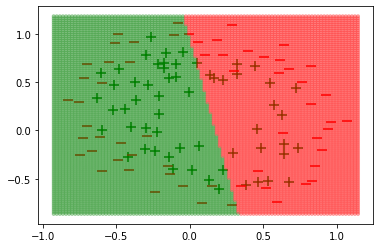

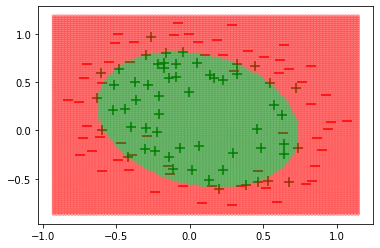

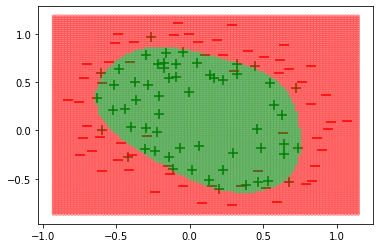

In [8]:
graph(chips_x, chips_y, kernels['linear'], chip_res['linear'][1:])
graph(chips_x, chips_y, kernels['polynomial'], chip_res['polynomial'][1:])
graph(chips_x, chips_y, kernels['gaussian'], chip_res['gaussian'][1:])

In [9]:
print("Geyser")
geyser_res = find_best(8, accuracy, geyser_x, geyser_y)

Geyser
linear: assessment = 0.9054054054054054, best C = 0.5, best unnecessary = 0
polynomial: assessment = 0.8738738738738738, best C = 0.05, best degree = 2
gaussian: assessment = 0.8963963963963963, best C = 0.5, best beta = 1


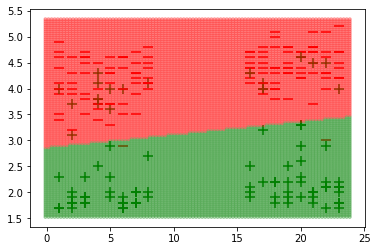

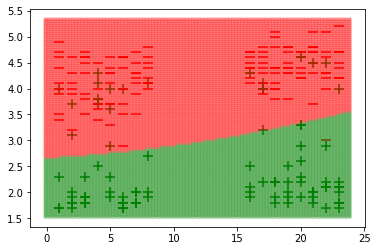

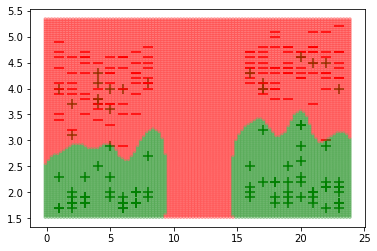

In [10]:
graph(geyser_x, geyser_y, kernels['linear'], geyser_res['linear'][1:])
graph(geyser_x, geyser_y, kernels['polynomial'], geyser_res['polynomial'][1:])
graph(geyser_x, geyser_y, kernels['gaussian'], geyser_res['gaussian'][1:])